In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
class PinGroupDataset(Dataset):
    def __init__(self, data_frame, transform=None):
        self.data = data_frame
        self.transform = transform or transforms.Compose([
            transforms.Resize((128, 128)),  # Resize images to 128x128
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        group_id = self.data.iloc[idx, 3]  # group_id

        if self.transform:
            image = self.transform(image)

        return image, group_id

In [3]:
# Load the dataset
csv_file = 'annotated_data.csv'  
full_dataset = pd.read_csv(csv_file)

# Encode group_id to integers
label_encoder = LabelEncoder()
full_dataset['group_id'] = label_encoder.fit_transform(full_dataset['group_id'])

# Split the dataset into training and validation sets
train_data, val_data = train_test_split(full_dataset, test_size=0.2, random_state=42)

# Create datasets for training and validation
train_dataset = PinGroupDataset(data_frame=train_data)
val_dataset = PinGroupDataset(data_frame=val_data)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


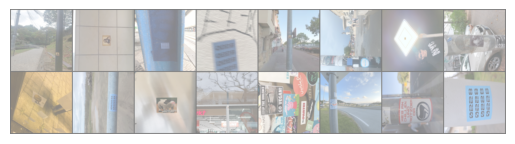

aa43f01d-5faa-4489-838d-4fe3b373e7d5 aa43f01d-5faa-4489-838d-4fe3b373e7d5 78f4e676-3bc9-41ae-870f-73fcb1ec557c 78f4e676-3bc9-41ae-870f-73fcb1ec557c aa43f01d-5faa-4489-838d-4fe3b373e7d5 78f4e676-3bc9-41ae-870f-73fcb1ec557c 78f4e676-3bc9-41ae-870f-73fcb1ec557c dad13a7d-a6ca-4f29-a201-05071603a665 1921ac00-4887-4ed9-a49c-dca40c39d6e1 78f4e676-3bc9-41ae-870f-73fcb1ec557c 09ff749a-904e-426d-98e7-8f3d0968c6f9 aa43f01d-5faa-4489-838d-4fe3b373e7d5 7647c37c-20b0-4331-a05a-bc914f102bbb aa87ddf0-01f2-4455-b08f-a7e2a4b8f344 0211dabb-aa48-4ecc-8627-9ad7f3468a3b 78f4e676-3bc9-41ae-870f-73fcb1ec557c


In [4]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axes
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
# Convert labels to their original string representation
classes = label_encoder.inverse_transform(labels.numpy())
print(' '.join(f'{classes[j]:5s}' for j in range(len(classes))))

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)  # Conv layer with 3x3 kernel, depth=8
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)  # Conv layer with 3x3 kernel, depth=16
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # Max pooling with 2x2 kernel
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)  # Conv layer with 3x3 kernel, depth=32
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)  # Conv layer with 3x3 kernel, depth=64
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # Max pooling with 2x2 kernel
        
        # Calculate the output size after the conv layers
        # Input size: 128x128
        # After conv1: 126x126 (128 - 3 + 1)
        # After conv2: 124x124 (126 - 3 + 1)
        # After pool1: 62x62 (124 / 2)
        # After conv3: 60x60 (62 - 3 + 1)
        # After conv4: 58x58 (60 - 3 + 1)
        # After pool2: 29x29 (58 / 2)
        
        self.fc1 = nn.Linear(64 * 29 * 29, 4096)  # Fully connected with 4096 nodes
        self.fc2 = nn.Linear(4096, num_classes * 50)  # Fully connected with 1000 nodes
        self.fc3 = nn.Linear(num_classes * 50, num_classes)  # Fully connected with 10 nodes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:


import torch.optim as optim

net = Net(num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        loss = loss.item()
       
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss:.3f}')
        del inputs, labels, outputs, loss
        torch.cuda.empty_cache()

print('Finished Training')



[1,     1] loss: 4.023
[1,     2] loss: 4.032
[1,     3] loss: 4.028
[1,     4] loss: 4.029
[1,     5] loss: 4.024
[1,     6] loss: 4.023
[1,     7] loss: 4.022
[1,     8] loss: 4.022
[1,     9] loss: 4.020
[1,    10] loss: 4.019
[1,    11] loss: 4.007
[1,    12] loss: 4.011
[1,    13] loss: 4.005
[1,    14] loss: 4.002
[1,    15] loss: 3.999
[1,    16] loss: 3.997
[1,    17] loss: 4.000
[1,    18] loss: 3.998
[1,    19] loss: 3.994
[1,    20] loss: 3.979
[1,    21] loss: 3.983
[1,    22] loss: 3.982
[1,    23] loss: 3.981
[1,    24] loss: 3.973
[1,    25] loss: 3.992
[1,    26] loss: 3.967
[1,    27] loss: 3.958
[1,    28] loss: 3.939
[1,    29] loss: 3.945
[1,    30] loss: 3.928
[1,    31] loss: 3.958
[1,    32] loss: 3.930
[1,    33] loss: 3.969
[1,    34] loss: 3.977
[1,    35] loss: 3.910
[1,    36] loss: 3.902
[1,    37] loss: 3.914
[1,    38] loss: 3.924
[1,    39] loss: 3.915
[1,    40] loss: 3.938
[1,    41] loss: 3.945
[1,    42] loss: 3.887
[1,    43] loss: 3.961
[1,    44] 

Accuracy for class: 0211dabb-aa48-4ecc-8627-9ad7f3468a3b is 0.0 %
Accuracy for class: 07a84a5b-4f24-4f0c-869b-f992031ce10e is 0.0 %
Accuracy for class: 093bc12a-de4d-4659-ba10-8fd11eed933c is 0.0 %
Accuracy for class: 09ff749a-904e-426d-98e7-8f3d0968c6f9 is 0.0 %
Accuracy for class: 0e7f8dde-0b23-40a7-822c-40eeb115d38d is N/A (no predictions)
Accuracy for class: 101c99e6-3c77-4f5d-9bcd-61ca9979d0f1 is 0.0 %
Accuracy for class: 12e53864-c706-4fb1-b0be-6f59f4842878 is 0.0 %
Accuracy for class: 18278583-7ed5-4080-bd69-5760b05f8c6c is 0.0 %
Accuracy for class: 1921ac00-4887-4ed9-a49c-dca40c39d6e1 is 0.0 %
Accuracy for class: 1dd369a3-1299-4758-ace2-c2c10f113489 is N/A (no predictions)
Accuracy for class: 1e4efe6e-04a1-4671-85cc-21ee1a8c55d1 is N/A (no predictions)
Accuracy for class: 2022078f-6d3a-4dc3-839f-c91749aed74c is 0.0 %
Accuracy for class: 207601f0-98ac-4506-9e1b-461ae1320592 is N/A (no predictions)
Accuracy for class: 22276aa4-8b77-499e-a1f0-768a3925ec49 is 0.0 %
Accuracy for cla

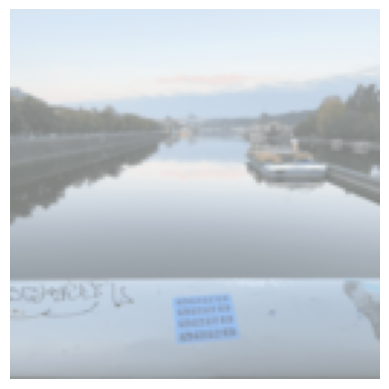

Correct example for class aa43f01d-5faa-4489-838d-4fe3b373e7d5:


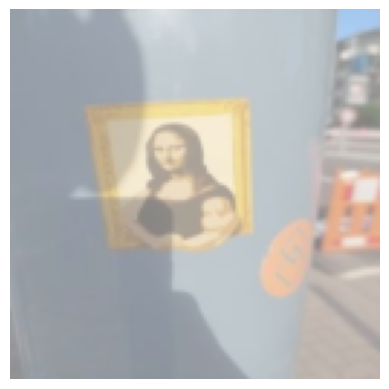

Correct example for class dad13a7d-a6ca-4f29-a201-05071603a665:


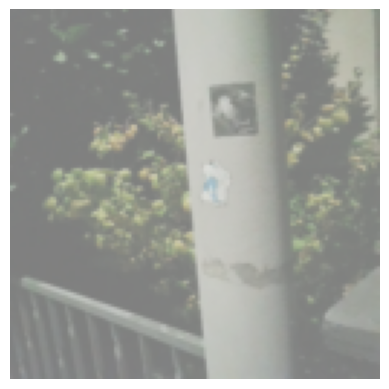

In [18]:
# Prepare to count predictions for each class and store one correct example
classes = label_encoder.classes_
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct_examples = {classname: None for classname in classes}

# Again, no gradients needed
with torch.no_grad():
    for i, data in enumerate(val_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)  # Move inputs and labels to the same device as the model
        outputs = net(inputs)  # Use inputs instead of images
        _, top3_predicted = torch.topk(outputs, 3, dim=1)  # Get top 3 predictions
        for img, label, top3 in zip(inputs, labels, top3_predicted):
            if label in top3:
                correct_pred[classes[label]] += 1
                # Store one correct example per class
                if correct_examples[classes[label]] is None:
                    correct_examples[classes[label]] = img.cpu()
            total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] > 0:  # Avoid division by zero
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    else:
        print(f'Accuracy for class: {classname:5s} is N/A (no predictions)')

# Show one correct image for each class
for classname, img in correct_examples.items():
    if img is not None:
        print(f"Correct example for class {classname}:")
        imshow(img)
